In [7]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append(os.path.abspath("../src"))  # adjust if the notebook runs elsewhere

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from utils import show_prompt
from Autonomous_Learning_Agent.prompts import clarify_with_user_instructions
show_prompt(clarify_with_user_instructions,"clarify_with_user_instructions")

╭──────────────────────────────────────── clarify_with_user_instructions ─────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  These are the messages that have been exchanged so far from the user asking for the report:                    │
│  <Messages>                                                                                                     │
│  {messages}                                                                                                     │
│  </Messages>                                                                                                    │
│                                                                                                                 │
│  Today's date is {date}.                                                                                        │
│                                                                                                                 │
│  Assess whether you need to ask a clarifying question, or if the user has already provided enough information   │
│  for you to start research.                                                                                     │
│  IMPORTANT: If you can see in the messages history that you have already asked a clarifying question, you       │
│  almost always do not need to ask another one. Only ask another question if ABSOLUTELY NECESSARY.               │
│                                                                                                                 │
│  If there are acronyms, abbreviations, or unknown terms, ask the user to clarify.                               │
│  If you need to ask a question, follow these guidelines:                                                        │
│  - Be concise while gathering all necessary information                                                         │
│  - Make sure to gather all the information needed to carry out the research task in a concise, well-structured  │
│  manner.                                                                                                        │
│  - Use bullet points or numbered lists if appropriate for clarity. Make sure that this uses markdown            │
│  formatting and will be rendered correctly if the string output is passed to a markdown renderer.               │
│  - Don't ask for unnecessary information, or information that the user has already provided. If you can see     │
│  that the user has already provided the information, do not ask for it again.                                   │
│                                                                                                                 │
│  Respond in valid JSON format with these exact keys:                                                            │
│  "need_clarification": boolean,                                                                                 │
│  "question": "<question to ask the user to clarify the report scope>",                                          │
│  "verification": "<verification message that we will start research>"                                           │
│                                                                                                                 │
│  If you need to ask a clarifying question, return:                                                              │
│  "need_clarification": true,                                                                                    │
│  "question": "<your clarifying question>",                                                                      │
│  "verification": ""                                                                                             │
│                                                       

In [9]:

# %%writefile ../src/Autonomous_Learning_Agent/state_scope.py
import operator
from typing_extensions import Optional,Annotated,List,Sequence

from langchain_core.messages import BaseMessage
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages
from pydantic import BaseModel,Field

class AgentInputState(MessagesState):
    """Input state for the full agent - only contains messages from user input."""
    pass

class AgentState(MessagesState):
    """
    Main state for the full multi-agent research system.
    
    Extends MessagesState with additional fields for research coordination.
    Note: Some fields are duplicated across different state classes for proper
    state management between subgraphs and the main workflow.
    """
    research_brief:Optional[str]
    supervisor_messages:Annotated[Sequence[BaseMessage],add_messages]
    raw_notes:Annotated[list[str],operator.add]=[]
    notes:Annotated[list[str],operator.add]=[]
    final_report:str

# structured output schema
class ClarifyWithUser(BaseModel):
    """Schema for user clarification decision and questions."""
    need_clarification:bool=Field(
        description="Whether the user needs to be asked a clarification qustion"
    )
    question:str=Field(
        description=" A question to ad the user to clarify the report scope"
    )
    verification:str=Field(
        description="verify message that will start research after user provided the necessary information"
    )
class ResearchQuestion(BaseModel):
    """Schema for structured research brief generation."""
    research_brief:str=Field(
        description="A research qustion that will be used to guide the research"
    )

In [ ]:
# %%writefile ../src/Autonomous_Learning_Agent/research_agent_scope.py
from datetime import datetime
from email import message
from urllib import response
from langchain_core import messages
from typing_extensions import Literal
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage,AIMessage,get_buffer_string
from langgraph.graph import StateGraph,START,END
from langgraph.types import Command
from Autonomous_Learning_Agent.prompts import clarify_with_user_instructions,transform_messages_into_research_topic_prompt

def get_today_str() -> str:
    """Get current date in human readable format"""
    return datetime.now().strftime("%a %b %#d,%Y")

model=init_chat_model("google_genai:models/gemini-flash-lite-latest")

def clarify_with_user(state: AgentState):
    """
    Determine if the user's request contains sufficient information to proceed with research.
    
    Uses structured output to make deterministic decisions and avoid hallucination.
    Routes to either research brief generation or ends with a clarification question.
    """
    # Set up structured output model
    structured_output_model = model.with_structured_output(ClarifyWithUser)

    # Invoke the model with clarification instructions
    response = structured_output_model.invoke([
        HumanMessage(content=clarify_with_user_instructions.format(
            messages=get_buffer_string(messages=state["messages"]), 
            date=get_today_str()
        ))
    ])
    
    # Route based on clarification need
    if response.need_clarification:
        return Command(
            goto=END, 
            update={"messages": [AIMessage(content=response.question)]}
        )
    else:
        return Command(
            goto="write_research_brief", 
            update={"messages": [AIMessage(content=response.verification)]}
        )

def write_research_brief(state: AgentState):
    """
    Transform the conversation history into a comprehensive research brief.
    
    Uses structured output to ensure the brief follows the required format
    and contains all necessary details for effective research.
    """
    # Set up structured output model
    structured_output_model = model.with_structured_output(ResearchQuestion)
    
    # Generate research brief from conversation history
    response =structured_output_model.invoke([
        HumanMessage(content=transform_messages_into_research_topic_prompt.format(
            messages=get_buffer_string(state.get("messages", [])),
            date=get_today_str()
        ))
    ])
    
    # Update state with generated research brief and pass it to the supervisor
    return {
        "research_brief": response.research_brief,
        "supervisor_messages": [HumanMessage(content=f"{response.research_brief}.")]
    }
deep_research_builder=StateGraph(AgentState,input_schema=AgentInputState)
deep_research_builder.add_node("clarify_with_user",clarify_with_user)
deep_research_builder.add_node("write_research_brief",write_research_brief)

deep_research_builder.add_edge(START,"clarify_with_user")
deep_research_builder.add_edge("write_research_brief",END)
# scope_research=deep_research_builder.compile()


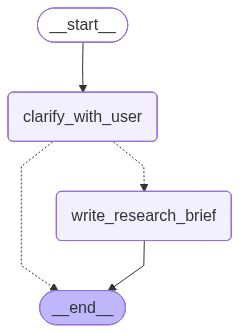

In [11]:
# Compile with in-memory checkpointer to test in notebook
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver

checkpointer = InMemorySaver()
scope = deep_research_builder.compile(checkpointer=checkpointer)
display(Image(scope.get_graph(xray=True).draw_mermaid_png()))

In [12]:
# Run the workflow
# from utils import format_mess/ages
from langchain_core.messages import HumanMessage
thread = {"configurable": {"thread_id": "1"}}
result = scope.invoke({"messages": [HumanMessage(content="I want to learn about python.")]}, config=thread)
from utils import format_messages
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to learn about python.                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Python is a broad topic. To provide a helpful report, could you specify what aspects of Python you are          │
│ interested in? For example, are you looking for information on:                                                 │
│ * Introduction and basic concepts (e.g., syntax, data types)?                                                   │
│ * Specific applications (e.g., web development, data science, scripting)?                                       │
│ * Learning resources or tutorials?                                                                              │
│ * History or recent developments?                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [13]:
result = scope.invoke({"messages": [HumanMessage(content="the basics of python.")]}, config=thread)
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to learn about python.                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Python is a broad topic. To provide a helpful report, could you specify what aspects of Python you are          │
│ interested in? For example, are you looking for information on:                                                 │
│ * Introduction and basic concepts (e.g., syntax, data types)?                                                   │
│ * Specific applications (e.g., web development, data science, scripting)?                                       │
│ * Learning resources or tutorials?                                                                              │
│ * History or recent developments?                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ the basics of python.                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Thank you for clarifying. I will now prepare a report covering the basics of Python, including syntax and       │
│ fundamental concepts. Research is starting now.                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [14]:
# result=scope.invoke({"messages":[HumanMessage(content=" beginer ")]},config=thread)
# format_messages(result['messages'])

In [15]:
from rich.markdown import Markdown
Markdown(result["research_brief"])




What are the fundamental basics of the Python programming language, specifically covering its syntax and core      
fundamental concepts, suitable for an introductory learner? The research should detail foundational elements       
without assuming knowledge of advanced applications or specific learning resources, as these dimensions were not   
specified by the user.